Demo - Training Separate vs Shared Networks

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Spandan-Madan/generalization_biased_category_pose/blob/main/demos/neural_activity.ipynb)

In [1]:
import numpy as np
import pickle
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
sns.set_context("poster")
sns.set_palette("Set1", 8, .75)

In [2]:
import os
def create_folder(path):
    if not os.path.isdir(path):
        os.mkdir(path)
print('Cloning code base to colab....')
create_folder('data')
print('Downloading iLab activations....')
!wget https://www.dropbox.com/s/9anio3er0svs90b/ilab_activations_demo.zip?dl=0 -O data/ilab_activations_demo.zip
print('Unzipping data')
!cd data && unzip ilab_activations_demo.zip


Cloning code base to colab....
--2021-03-04 00:24:24--  https://www.dropbox.com/s/9anio3er0svs90b/ilab_activations_demo.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/9anio3er0svs90b/ilab_activations_demo.zip [following]
--2021-03-04 00:24:24--  https://www.dropbox.com/s/raw/9anio3er0svs90b/ilab_activations_demo.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc625b03edda33238ada0d3c0aee.dl.dropboxusercontent.com/cd/0/inline/BKBeHunLrAbb0rhWuEBGiqyZ8lXyK2G7yZJi-qJGaW1KIWQTAeM-Z8hMm2N203g-fLU-Sx0rvVUeprTMaF2F1CXpkhi_3KYxzIulxRJPNOEoP5xkWzzbi8DnjDuZ_Bai8UM/file# [following]
--2021-03-04 00:24:24--  https://uc625b03edda33238ada0d3c0aee.dl.dropboxusercontent.com/cd/0/inline/BKBeHunLrAbb0rhWuEBGiqyZ8lXyK2G7yZJi

In [2]:
def create_dataframe():
    df = pd.DataFrame(columns=['backbone','network','branch','num_compositions',
                           'composition_selectivity', 'composition_selectivity_stringent',
                           'composition_0', 'composition_1',
                          'attribute_selectivity', 'attribute_selectivity_stringent', 'attribute_invariance', 
                           'attribute_type', 'attribute_instance', 'layer'])
    return df

def analysis(backbone, name, branch, layer, func_loaders, names_tasks):
    load_and_average = func_loaders[0]
    get_path_network = func_loaders[1]

    
    data_analysis = []
    for T in [0,1]: #For each attribute 
        for comp in C: #For each composition
            M = load_and_average(get_path_network(name, branch, comp, layer), branch, layer)

            num_neurons = np.shape(M)[2]
            num_compositions = np.shape(M)[0]
            #Normalize
            M = (M-np.tile(np.min(M,axis=(0,1)),[num_compositions,num_compositions,1]))
            M = M/np.tile(np.max(M,axis=(0,1)),[num_compositions,num_compositions,1])
            

            #Classify units
            A = np.zeros((2,num_neurons))
            A[0,:] = np.max(np.mean(M,axis=0), axis=0 )   
            A[1,:] = np.max(np.mean(M,axis=1), axis=0 )
            type_unit = np.argmax(A, axis=0)

            num_units = np.shape(M)[-1]

            for k in range(num_units):
                if type_unit[k] == T:
                    continue

                clust = np.argmax(np.max(M[:,:,k], axis=type_unit[k]), axis=0 )
                
                entry = {'backbone': backbone, 'network': name, \
                         'branch': branch, 'num_compositions': comp}
                    
                if type_unit[k] == 0:
                    worse_cluster = np.min(M[:,clust,k])
                    ave_cluster = np.mean(M[:,clust,k])
                    invariance = np.max(M[:,clust,k])
                    best_outside = np.mean(np.delete(M[:,:,k], (clust), axis=1))
                    best_outside_case = np.max(np.delete(M[:,:,k], (clust), axis=1))
                else:
                    worse_cluster = np.min(M[clust,:,k])
                    ave_cluster = np.mean(M[clust,:,k])
                    invariance = np.max(M[clust,:,k])
                    best_outside = np.mean(np.delete(M[:,:,k], (clust), axis=0))
                    best_outside_case = np.max(np.delete(M[:,:,k], (clust), axis=0))


                    
                entry['attribute_selectivity'] = (ave_cluster - best_outside)/(ave_cluster + best_outside)
                entry['attribute_selectivity_stringent'] = \
                    (worse_cluster - best_outside_case)/(worse_cluster + best_outside_case)
                entry['attribute_invariance'] = (worse_cluster)
                entry['attribute_instance'] = clust
                entry['attribute_type'] = names_tasks[type_unit[k]]
                
                mm = np.unravel_index(np.argmax(M[:,:,k]), np.shape(M[:,:,k]))
                flat=M[:,:,k].flatten()
                flat.sort()

                entry['composition_selectivity'] = (flat[-1] - np.mean(flat[:-2]))/(flat[-1] + np.mean(flat[:-2]))
                entry['composition_selectivity_stringent'] = \
                        (flat[-1] - flat[-2])/(flat[-1] + flat[-2])
                entry['composition_0'] = mm[0]
                entry['composition_1'] = mm[1]
                entry['layer'] = layer
            
                data_analysis.append(entry)
                
    return data_analysis

In [3]:
def get_path_network(branching, attribute, c, layer):
    if attribute == 'object':
        attribute = 'car_model'
    if attribute == 'viewpoint':
        attribute = 'rotation'
        
    if branching == 'split':
        return 'data/ilab_early_branching_avgpool_' + attribute + \
            '_branch_' + str(c) + '_compositions_seen.p'
    elif branching == 'separate':
        return 'data/ilab_single_task_' + attribute + '_avgpool_' + str(c) + '_compositions_seen.p'
    elif branching == 'together':
        return 'data/ilab_late_branching_avgpool_' + str(c) + '_compositions_seen.p'

def load_and_average(name, attribute, layer):
    M = pickle.load(open(name, 'rb'))
    return M  


C = [6,12,18,24,30,36]
num_compositions = 6
names_tasks = ['object', 'viewpoint']
networks = ['together','split','separate']

df = create_dataframe()

for net in networks:
    for branch in names_tasks:
        df = df.append(analysis('resnet', net, branch, 0, [load_and_average, get_path_network], names_tasks))

def rename_what_where(df):
    df.attribute_type = df.attribute_type.replace({'scale':'where', 'position':'where', 'viewpoint':
                              'where', 'object':'what'})
    df.branch = df.branch.replace({'scale':'where', 'position':'where', 'viewpoint':
                              'where', 'object':'what'})
    df.network = df.network.replace({'together':'shared','together-wider':'sh.-wide'})
    return df

df = rename_what_where(df)

In [4]:
def plot_number_neurons_branches(df_main, layer, networks, tasks, num_compositions, name,legend=False, title="",factor_num_compositions=1):
    sns.set_context("poster")
    sns.set_palette("Set1", 8, .75)

    df = df_main[df_main.layer == layer]
    df = df_main[(df_main.layer == layer)]
    df = df[(((df.branch==tasks[0]) & (df.attribute_type==tasks[0])) |  \
                  ((df.branch==tasks[1]) & (df.attribute_type==tasks[1])))]
    df = df.groupby(['network', 'branch', 'layer', 'num_compositions', 'attribute_type']).size().reset_index(name='counts')
    
    df.loc[df.layer==layer,'counts'] /= 512 
    df.loc[df.layer==layer,'counts'] *= 100 

    
    x = sns.color_palette("Set1", 7, .75)
    tmp = x[0]
    x[0] = x[1]
    x[1] = tmp
    x[2] = x[5]
    sns.set_palette(x)
    
    df.num_compositions = 100*df.num_compositions/factor_num_compositions
    plt.figure(figsize=(4,4))
    df = df.rename(columns = {'attribute_type': 'Task', 'counts':'% Cat./Pose Neurons',
                             'num_compositions': '% Seen Combinations'})
    
    ax = sns.lineplot(x='% Seen Combinations', y='% Cat./Pose Neurons', hue='network',\
                 hue_order= networks, style="Task", \
                 err_style="band", \
                 data=df, markers=True,dashes=['', ''])
    
    
    sns.despine()
    plt.ylim((0,103))
    plt.yticks([0,25, 50, 75, 100])
    plt.xticks([25,50,75])
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(16)
    plt.title(title,fontsize=18)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    if legend:
        h,l = ax.get_legend_handles_labels()

        l[0] = "Network"
        l[4] ="Category"
        l[5] ="Pose"
        ax.legend(h,l,loc=1,bbox_to_anchor=(1, 0.27), borderaxespad=0.,fontsize='xx-small', ncol=2, columnspacing=0.5)
    else:
        plt.legend().set_visible(False)


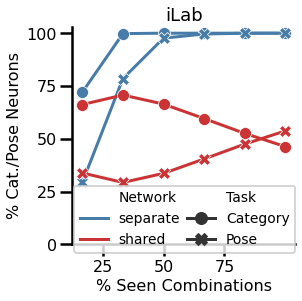

In [5]:
plot_number_neurons_branches(df, layer = 0, networks = ['separate','shared'], \
                     tasks = ['what', 'where'], title="iLab", num_compositions = 36,\
                   name='iLab',factor_num_compositions=36, legend = True) 

In [6]:
def plot_neural_activity(df_main, layer, networks, tasks, name, num_compositions, title="",factor_num_compositions=1):
    sns.set_context("poster")
    sns.set_palette("Set1", 8, .75)
    
    df = df_main[df_main.layer == layer]
    df = df[(((df.branch==tasks[0]) & (df.attribute_type==tasks[0])) |  \
                  ((df.branch==tasks[1]) & (df.attribute_type==tasks[1])))]
    
    df["Specialization Score"]=np.sqrt(df["attribute_invariance"]*df["attribute_selectivity"])
    df.num_compositions = 100*df.num_compositions/factor_num_compositions

    plt.figure()

        
    df = df.rename(columns = {'network':'Network', 
                              'attribute_type': 'Task', 'attribute_selectivity': 'Selectivity Score',
                              'attribute_invariance': 'Invariance Score',
                              'num_compositions': '% Seen Combinations'})
    

    x = sns.color_palette("Set1", 7, .75)
    tmp = x[0]
    x[0] = x[1]
    x[1] = tmp
    x[2] = x[5]
    sns.set_palette(x)
    
    plt.figure(figsize=(4,4))

    ax = sns.lineplot(x='% Seen Combinations', y='Specialization Score', hue='Network', hue_order= networks, style="Task",
              data=df, estimator=np.median, markers=True,dashes=['', ''])
    sns.despine()
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    
    plt.ylim((-0.,0.9))
    plt.yticks([0,0.2,0.4,0.6,0.8])
    plt.xticks([25,50,75])
    plt.legend().set_visible(False)
    plt.ylabel('Specialization Score')

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(16)
    
    plt.title("iLab",fontsize=18)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

    h,l = ax.get_legend_handles_labels()

    l[0] ="Network"
    l[4] ="Category"
    l[5] ="Pose"
    ax.legend(h,l,loc=1,bbox_to_anchor=(1, 0.27), borderaxespad=0.,fontsize='xx-small', ncol=2, columnspacing=0.5)

    

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 432x288 with 0 Axes>

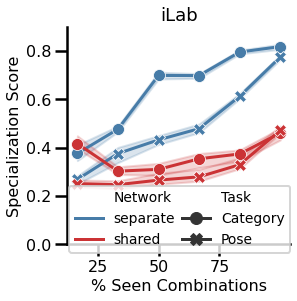

In [7]:
plot_neural_activity(df, layer = 0, networks = ['separate','shared'], \
                     tasks = ['what', 'where'], num_compositions = 9, name='iLab',factor_num_compositions=36) 